# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Загружаем данные monthly-australian-wine-sales.csv, парсим даты

In [8]:
data = pd.read_csv("monthly-australian-wine-sales.csv",parse_dates=["month"],index_col=["month"])

In [12]:
data.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


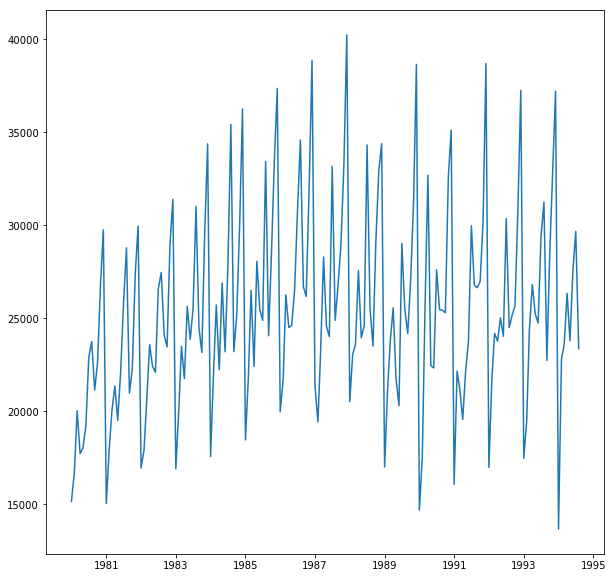

In [14]:
figure = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plt.plot(data.index.values,data.sales)
plt.show()

In [ ]:
# Ваш код

Проверка стационарности и STL-декомпозиция ряда:

In [28]:
# Смотрим фцункции seasonal_decompose и stattools.adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
fulered = adfuller(data.sales)
print("P-value of dikki-fuller is {0}".format(fulered[1]))

P-value of dikki-fuller is 0.05116115205187653


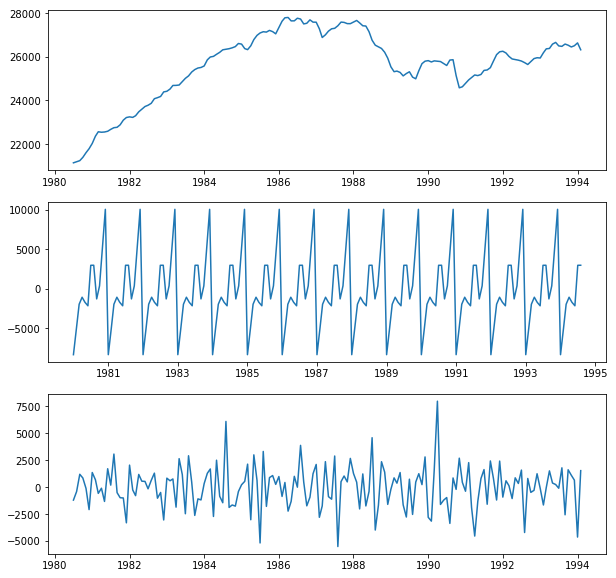

In [27]:
fig = plt.figure(figsize=(10,10))
seasoned = seasonal_decompose(data.sales)
plt.subplot(3,1,1)
plt.plot(seasoned.trend)
plt.subplot(3,1,2)
plt.plot(seasoned.seasonal)
plt.subplot(3,1,3)
plt.plot(seasoned.resid)

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [72]:
# смотрим функцию boxcox - посмотрим критерий Дики-Фуллера
from scipy.stats import boxcox
box_coxed = boxcox(data.sales)
data["box_cox"] = box_coxed[0]
box_coxed_fulered = adfuller(box_coxed[0])
print("P-value of boxed-coxed data: {0}".format(box_coxed_fulered[1]))
lmbda = box_coxed[1]

P-value of boxed-coxed data: 0.40310709759477115


### Стационарность

Что с гипотезей нестационарности и трендом?
Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

P-value of dikki-fuller is 0.047546403683154534


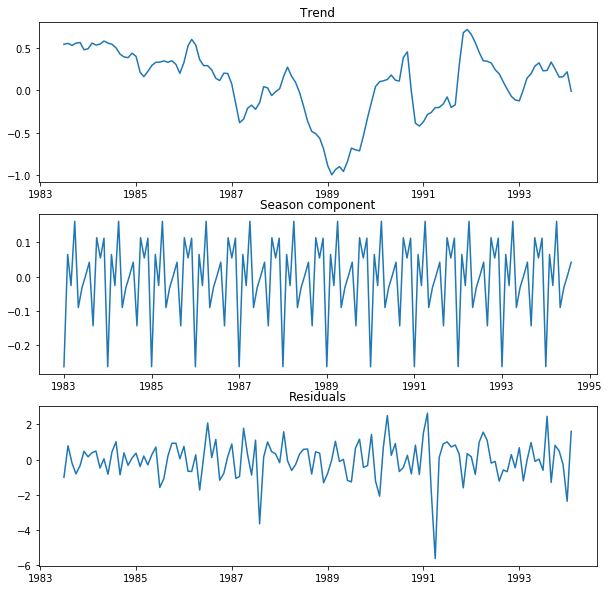

In [44]:
data['sales_box_diff'] = data.box_cox - data.box_cox.shift(12) #shift смещает данные
data.dropna(inplace=True)
# seasonal_decompose и adfuller
fulered = adfuller(data.sales_box_diff)
print("P-value of dikki-fuller is {0}".format(fulered[1]))
fig = plt.figure(figsize=(10,10))
seasoned = seasonal_decompose(data.sales_box_diff)
plt.subplot(3,1,1)
plt.title("Trend")
plt.plot(seasoned.trend)
plt.subplot(3,1,2)
plt.title("Season component")
plt.plot(seasoned.seasonal)
plt.subplot(3,1,3)
plt.title("Residuals")
plt.plot(seasoned.resid)

Что с гипотезей нестационарности и трендом?
Попробуем добавить ещё обычное дифференцирование:

P-value of dikki-fuller is 2.3925939009792027e-05


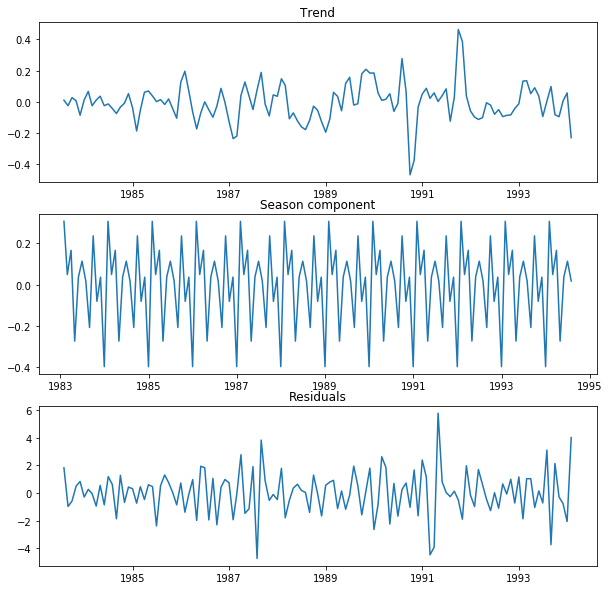

In [47]:
data['sales_box_diff2'] = data.sales_box_diff - data.sales_box_diff.shift(1)
data.dropna(inplace=True)
# seasonal_decompose и adfuller
fulered = adfuller(data.sales_box_diff2)
print("P-value of dikki-fuller is {0}".format(fulered[1]))
fig = plt.figure(figsize=(10,10))
seasoned = seasonal_decompose(data.sales_box_diff2)
plt.subplot(3,1,1)
plt.title("Trend")
plt.plot(seasoned.trend)
plt.subplot(3,1,2)
plt.title("Season component")
plt.plot(seasoned.seasonal)
plt.subplot(3,1,3)
plt.title("Residuals")
plt.plot(seasoned.resid)

Принимаем ли гипотезу нестационарности?

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

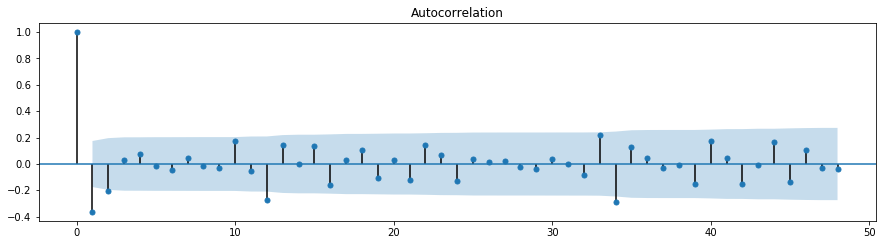

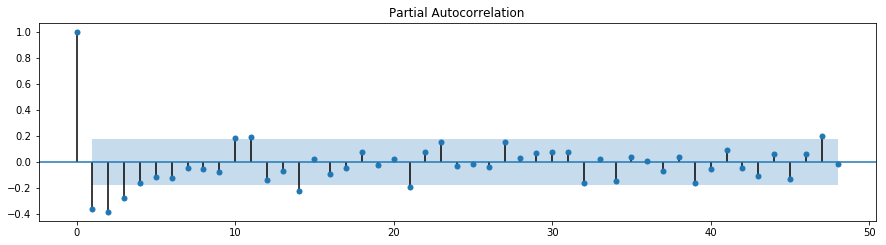

In [48]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [49]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [50]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [62]:
parameters_list[0]

(0, 0, 0, 0)

In [59]:
data.head()

,sales,box_cox,sales_box_diff,sales_box_diff2
month,,,,
1983-02-01,20045,39.832906,1.169042,1.190954
1983-03-01,23471,41.509320,1.424881,0.255838
1983-04-01,21747,40.690952,-0.863491,-2.288372
1983-05-01,25621,42.467937,1.453253,2.316744
1983-06-01,23859,41.687138,0.832416,-0.620837


In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [66]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(data.box_cox,order= (param[0],1,param[1]) , seasonal_order= (param[2],1,param[3],12))
        model = model.fit()
        # обучаем модель tsa.statespace.SARIMAX
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 26.7 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [67]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
24  (2, 1, 0, 1)  388.771432
4   (0, 1, 0, 1)  390.153573
28  (2, 2, 0, 1)  390.527874
26  (2, 1, 1, 1)  390.701504
36  (3, 1, 0, 1)  390.727254


Лучшая модель:

In [68]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            box_cox   No. Observations:                  139
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -189.386
Date:                            Thu, 07 Dec 2017   AIC                            388.771
Time:                                    18:04:41   BIC                            403.444
Sample:                                02-01-1983   HQIC                           394.734
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1318      0.097     -1.354      0.176      -0.323       0.059
ar.L2         -0.2153      0.128   

Её остатки:

Критерий Стьюдента: p=0.334878
Критерий Дики-Фуллера: p=0.000000


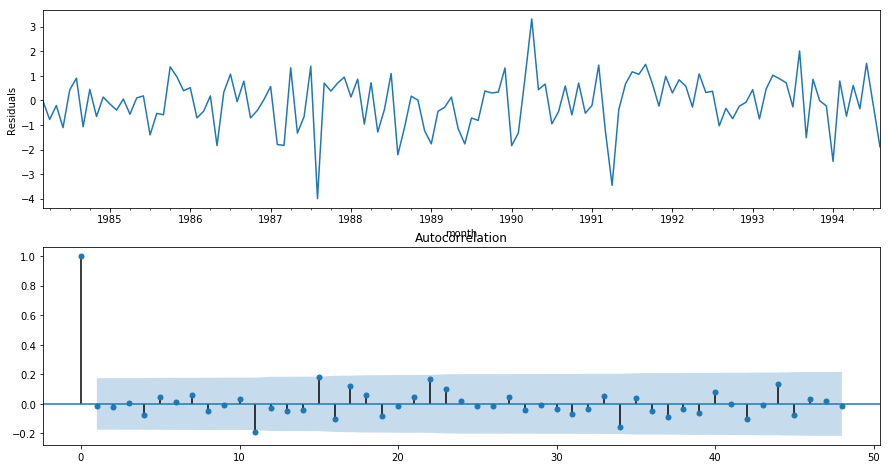

In [69]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

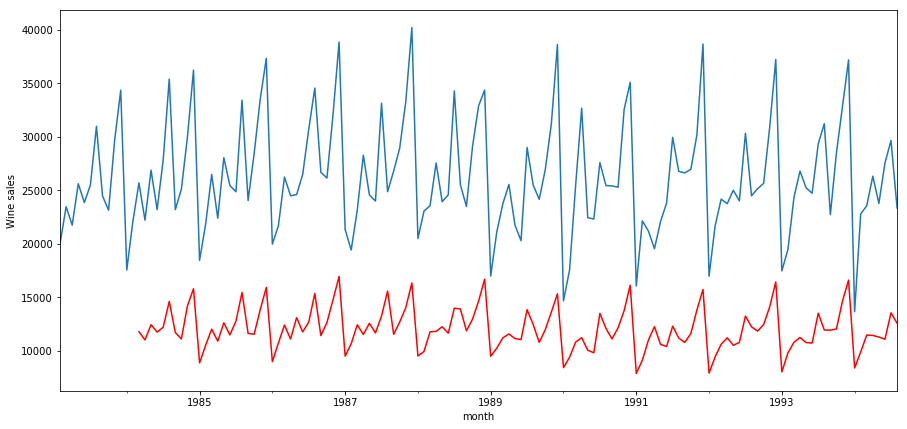

In [75]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.sales.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

In [ ]:
data2 = data[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()